In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

from multiprocessing import Pool

In [4]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

In [5]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'

In [16]:
import warnings
warnings.filterwarnings('ignore')

## Builtins

In [7]:
import healpy as hp

In [38]:
hp.pix2ang?

In [39]:
nside=8
arr = np.random.rand(hp.nside2npix(nside))
lon, lat = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), nest=True, lonlat=True)

In [43]:
arr[np.abs(lat)<60]= np.nan

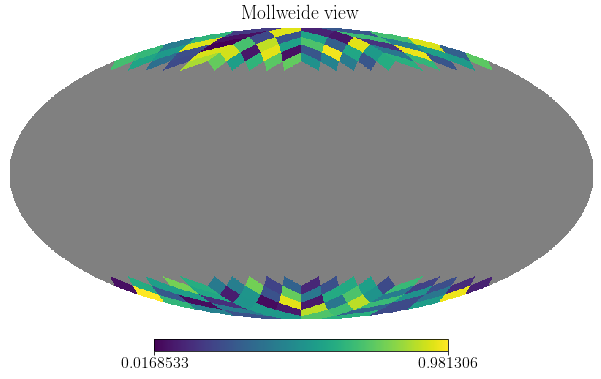

In [46]:
cmap = cm.viridis
hp.mollview(arr, nest=True, cmap=cmap)

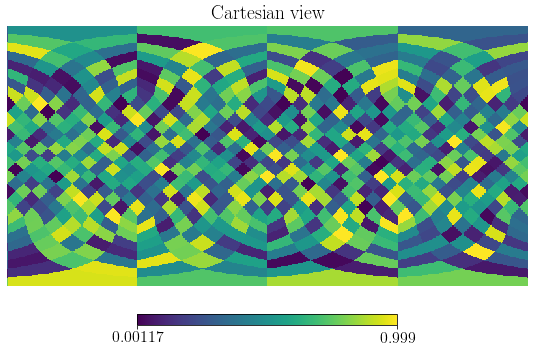

In [17]:
hp.cartview(arr, cmap=cmap)

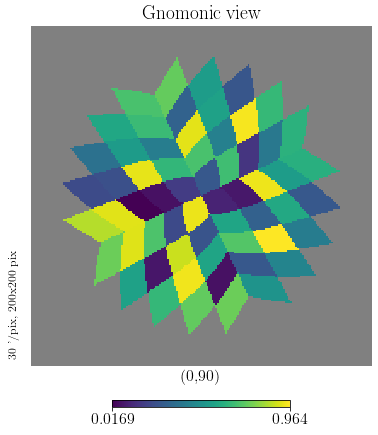

In [47]:
hp.gnomview(arr, cmap=cmap, nest=True, rot=(0,90, 25), xsize=200, reso=30.)

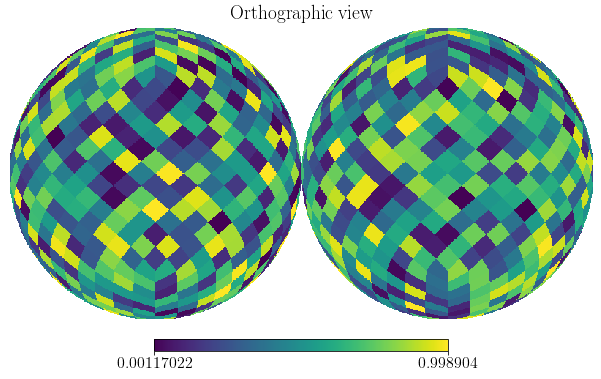

In [19]:
hp.orthview(arr, cmap=cmap)

In [ ]:
    # Ensure that the nside is valid
    nside = pixelfunc.get_nside(map)
    pixelfunc.check_nside(nside, nest=nest)

    if not (hold or sub or reuse_axes):
        f = pylab.figure(fig, figsize=(5.8, 6.4))
        if not margins:
            margins = (0.075, 0.05, 0.075, 0.05)
        extent = (0.0, 0.0, 1.0, 1.0)
    elif hold:
        f = pylab.gcf()
        left, bottom, right, top = np.array(pylab.gca().get_position()).ravel()
        if not margins:
            margins = (0.0, 0.0, 0.0, 0.0)
        extent = (left, bottom, right - left, top - bottom)
        f.delaxes(pylab.gca())
    elif reuse_axes:
        f = pylab.gcf()
    else:  # using subplot syntax
        f = pylab.gcf()
        if hasattr(sub, "__len__"):
            nrows, ncols, idx = sub
        else:
            nrows, ncols, idx = sub // 100, (sub % 100) // 10, (sub % 10)
        if idx < 1 or idx > ncols * nrows:
            raise ValueError("Wrong values for sub: %d, %d, %d" % (nrows, ncols, idx))
        c, r = (idx - 1) % ncols, (idx - 1) // ncols
        if not margins:
            margins = (0.01, 0.0, 0.0, 0.02)
        extent = (
            c * 1.0 / ncols + margins[0],
            1.0 - (r + 1) * 1.0 / nrows + margins[1],
            1.0 / ncols - margins[2] - margins[0],
            1.0 / nrows - margins[3] - margins[1],
        )
    extent = (
        extent[0] + margins[0],
        extent[1] + margins[1],
        extent[2] - margins[2] - margins[0],
        extent[3] - margins[3] - margins[1],
    )
    # f=pylab.figure(fig,figsize=(5.5,6))

    # Starting to draw : turn interactive off
    wasinteractive = pylab.isinteractive()
    pylab.ioff()
    try:
        map = pixelfunc.ma_to_array(map)
        if reuse_axes:
            ax = f.gca()
        else:
            ax = PA.HpxGnomonicAxes(
                f, extent, coord=coord, rot=rot, format=format, flipconv=flip
            )
            f.add_axes(ax)
        if remove_dip:
            map = pixelfunc.remove_dipole(map, gal_cut=gal_cut, nest=nest, copy=True)
        elif remove_mono:
            map = pixelfunc.remove_monopole(map, gal_cut=gal_cut, nest=nest, copy=True)
        img = ax.projmap(
            map,
            nest=nest,
            coord=coord,
            vmin=min,
            vmax=max,
            xsize=xsize,
            ysize=ysize,
            reso=reso,
            cmap=cmap,
            norm=norm,
            badcolor=badcolor,
            bgcolor=bgcolor,
        )
        if cbar:
            im = ax.get_images()[0]
            b = im.norm.inverse(np.linspace(0, 1, im.cmap.N + 1))
            v = np.linspace(im.norm.vmin, im.norm.vmax, im.cmap.N)
            if matplotlib.__version__ >= "0.91.0":
                cb = f.colorbar(
                    im,
                    ax=ax,
                    orientation="horizontal",
                    shrink=0.5,
                    aspect=25,
                    ticks=PA.BoundaryLocator(),
                    pad=0.08,
                    fraction=0.1,
                    boundaries=b,
                    values=v,
                    format=format,
                )
            else:
                cb = f.colorbar(
                    im,
                    orientation="horizontal",
                    shrink=0.5,
                    aspect=25,
                    ticks=PA.BoundaryLocator(),
                    pad=0.08,
                    fraction=0.1,
                    boundaries=b,
                    values=v,
                    format=format,
                )
            cb.solids.set_rasterized(True)
        ax.set_title(title)
        if not notext:
            ax.text(
                -0.07,
                0.02,
                "%g '/pix,   %dx%d pix"
                % (
                    ax.proj.arrayinfo["reso"],
                    ax.proj.arrayinfo["xsize"],
                    ax.proj.arrayinfo["ysize"],
                ),
                fontsize=12,
                verticalalignment="bottom",
                transform=ax.transAxes,
                rotation=90,
            )
            ax.text(
                -0.07,
                0.6,
                ax.proj.coordsysstr,
                fontsize=14,
                fontweight="bold",
                rotation=90,
                transform=ax.transAxes,
            )
            lon, lat = np.around(ax.proj.get_center(lonlat=True), ax._coordprec)
            ax.text(
                0.5,
                -0.03,
                "(%g,%g)" % (lon, lat),
                verticalalignment="center",
                horizontalalignment="center",
                transform=ax.transAxes,
            )
        if cbar:
            cb.ax.text(
                1.05,
                0.30,
                unit,
                fontsize=14,
                fontweight="bold",
                transform=cb.ax.transAxes,
                ha="left",
                va="center",
            )
        f.sca(ax)
    finally:
        pylab.draw()
        if wasinteractive:
            pylab.ion()
            # pylab.show()
        if no_plot:
            pylab.close(f)
            f.clf()
            ax.cla()
    if return_projected_map:
        return img
